## Preprocessing and Modeling of Credit Card Fraud Detection
### Imported all required libraries and packages for this section

In [1]:
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# High-cardinality encoder (fast, memory-safe)
from category_encoders.hashing import HashingEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # (kept for template; we do not have nulls)
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score
from sklearn.metrics import average_precision_score
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_curve, average_precision_score


from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

### Data Loading and Quick Checks

In [2]:
#data = pd.read_csv('eda_dataset.csv')
data = pd.read_csv('eda_dataset_withdate_time.csv')

In [3]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,tr_year,tr_month,tr_day,tr_hour,tr_minute,age,age_group,tr_day_name,distance_cust_merchant_km
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0,2019,1,1,0,0,31,adult,Tuesday,78.60
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0,2019,1,1,0,0,41,adult,Tuesday,30.21
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,0,2019,1,1,0,0,57,senior,Tuesday,108.21
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,0,2019,1,1,0,1,52,senior,Tuesday,95.67
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,0,2019,1,1,0,3,33,adult,Tuesday,77.56


In [4]:
# percentage of fraud and no fraud trasaction
print(data['is_fraud'].value_counts(normalize=True))

is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64


highly imbalance dataset with almost 99.5 % nofraud trasaction and 0.5% fraud trasaction

In [5]:
# removing fraud characters from merchant column 
data["merchant"] = data["merchant"].str.replace("^fraud_", "", regex=True)

In [6]:
# as amount column is right skewed so changes in into on logarithmic scale 
data["amt_log"] = np.log1p(data["amt"])

In [7]:
# feature enginnering : separated weekends from tr day 
data["is_weekend"] = (data["tr_day"] >= 5).astype(int)

In [8]:
# feature enginnering : created column for night hours 
data["is_night"] = ((data["tr_hour"] <= 5) | (data["tr_hour"] >= 22)).astype(int)

In [9]:
#Groups by each card (cc_num)
# For each card, uses a 24-hour rolling window based on the column trans_date_trans_time
# Counts transactions in last 24 hours
# Returns a Series aligned to original rows

# ensure datetime
data["trans_date_trans_time"] = pd.to_datetime(data["trans_date_trans_time"])

# sort
data = data.sort_values(["cc_num", "trans_date_trans_time"]).reset_index(drop=True)

# txns_last_24h = how many transactions happened for that card in last 24 hours
# rolling 24h count (includes current txn)
data["txns_last_24h"] = (
    data.groupby("cc_num")
        .rolling("24h", on="trans_date_trans_time")["trans_date_trans_time"]
        .count()
        .reset_index(level=0, drop=True)
        .to_numpy()
)

In [10]:
# top 20 credit card trasactions count in 24 hour 
#data["txns_last_24h"].sort_values(ascending = False).head(20)

In [11]:
#rolling mean amount + deviation feature
data = data.sort_values(["cc_num", "trans_date_trans_time"])
# Compute the rolling mean transaction amount for each card
# using the last ~20 transactions to capture recent spending behavior.
#Start computing the rolling mean only after at least 3 transactions
data["amt_mean_20"] = (
    data.groupby("cc_num")["amt"]
        .rolling(window=20, min_periods=3)
        .mean()
        .reset_index(level=0, drop=True)
)

In [12]:
print(' missing values after rolling window operation',data["amt_mean_20"].isnull().sum())
# Fill missing rolling means (early transactions) with global median
# to avoid null values and keep the feature model-safe.
data["amt_mean_20"] = data["amt_mean_20"].fillna(data["amt"].median())

 missing values after rolling window operation 1998


In [13]:

# Measure how unusual the current transaction amount is
# compared to the card’s recent average spending.
data["amt_vs_mean_ratio"] = data["amt"] / (data["amt_mean_20"] + 1e-6)

print(' top 10 deviation in current trasaction compare to average spending',data["amt_vs_mean_ratio"].sort_values(ascending= False).head(10))

#We create rolling features to capture a card’s recent spending behavior, which is often the strongest signal for detecting fraud.

 top 10 deviation in current trasaction compare to average spending 1351795    34.496733
86388      30.211591
1068647    27.919915
1068648    27.670811
677060     25.372391
218259     25.231401
462675     24.938883
1018148    24.456691
54245      23.296522
182363     23.198103
Name: amt_vs_mean_ratio, dtype: float64


In [14]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,age,age_group,tr_day_name,distance_cust_merchant_km,amt_log,is_weekend,is_night,txns_last_24h,amt_mean_20,amt_vs_mean_ratio
0,2019-01-01 12:47:15,60416207185,"Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Tuesday,127.61,2.112635,0,0,1.0,47.450,0.153214
1,2019-01-02 08:44:57,60416207185,Berge LLC,gas_transport,52.94,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Wednesday,110.31,3.987872,0,0,2.0,47.450,1.115701
2,2019-01-02 08:47:36,60416207185,Luettgen PLC,gas_transport,82.08,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Wednesday,21.79,4.419804,0,0,3.0,47.430,1.730550
3,2019-01-02 12:38:14,60416207185,Daugherty LLC,kids_pets,34.79,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Wednesday,87.20,3.577669,0,0,4.0,44.270,0.785859
4,2019-01-02 13:10:46,60416207185,Beier and Sons,home,27.18,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Wednesday,74.21,3.338613,0,0,4.0,40.852,0.665328


In [15]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'tr_year', 'tr_month', 'tr_day', 'tr_hour',
       'tr_minute', 'age', 'age_group', 'tr_day_name',
       'distance_cust_merchant_km', 'amt_log', 'is_weekend', 'is_night',
       'txns_last_24h', 'amt_mean_20', 'amt_vs_mean_ratio'],
      dtype='object')

In [16]:
data.shape

(1852394, 37)

In [17]:
# corelation of numeric features with target variable
data.corr(numeric_only=True)['is_fraud'].sort_values(ascending=False).head(10)

is_fraud             1.000000
amt_mean_20          0.246175
amt                  0.209308
amt_vs_mean_ratio    0.118310
amt_log              0.114310
is_night             0.088690
tr_hour              0.013196
age                  0.010927
tr_day               0.004562
txns_last_24h        0.004309
Name: is_fraud, dtype: float64

In [18]:
#do not delete this code
# unique count values in each categorical variable
data_c = data.select_dtypes(include=['object','category'])
for c in data_c:
    print( c ,':',data_c[c].nunique())

merchant : 693
category : 14
first : 355
last : 486
gender : 2
street : 999
city : 906
state : 51
job : 497
dob : 984
trans_num : 1852394
unix_time : 1819583
age_group : 3
tr_day_name : 7


In [19]:
# # do not delete this code
# #unique count values in each numerical variable
data_n = data.select_dtypes(include=['number'])
for c in data_n:
    print( c ,':',data_n[c].nunique())

cc_num : 999
amt : 60616
zip : 985
lat : 983
long : 983
city_pop : 891
merch_lat : 1754157
merch_long : 1809753
is_fraud : 2
tr_year : 2
tr_month : 12
tr_day : 7
tr_hour : 24
tr_minute : 60
age : 83
distance_cust_merchant_km : 14547
amt_log : 60616
is_weekend : 2
is_night : 2
txns_last_24h : 36
amt_mean_20 : 696705
amt_vs_mean_ratio : 1851684


In [20]:

# dropped id types colums with high unique nuerical counts and also dropped high cardibality categorical column

cols_to_drop = [
    "cc_num","trans_num","unix_time","first","last","street",
    "merchant","job","city","zip",
    "trans_date_trans_time","tr_year","tr_minute","tr_day_name",
    "lat","long","merch_lat","merch_long",
    "age_group","dob","amt",
    "tr_day","tr_month"   # drop raw calendar splits to reduce memorization
]

data1 = data.drop(columns=cols_to_drop, errors="ignore")


In [21]:
data1.shape

(1852394, 14)

In [22]:
data1.columns

Index(['category', 'gender', 'state', 'city_pop', 'is_fraud', 'tr_hour', 'age',
       'distance_cust_merchant_km', 'amt_log', 'is_weekend', 'is_night',
       'txns_last_24h', 'amt_mean_20', 'amt_vs_mean_ratio'],
      dtype='object')

### Train/Test Split

In [23]:
# STEP 1: Reduce from 1.8M to 100K while keeping original ratio
data_small, _ = train_test_split(data1,train_size=100_000,stratify=data1['is_fraud'],random_state=42)

# Check ratio preserved
print(data_small['is_fraud'].value_counts(normalize=True))

is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64


after reducing data size fraud rate is maintained 

In [24]:
# STEP 2: Now split data into train and test whike mainting fraud ration in both train and test data

X1 = data_small.drop(columns=['is_fraud'])
y1 = data_small['is_fraud']

X_train, X_test, y_train, y_test = train_test_split( X1, y1, test_size=0.2, stratify=y1,random_state=42)
print("Train ratio:", y_train.mean())
print("Test ratio:", y_test.mean())

Train ratio: 0.0052125
Test ratio: 0.0052


In [25]:
X_train

,category,gender,state,city_pop,tr_hour,age,distance_cust_merchant_km,amt_log,is_weekend,is_night,txns_last_24h,amt_mean_20,amt_vs_mean_ratio
1398673,misc_pos,F,PA,184,8,74,83.12,2.243896,0,0,4.0,43.4590,0.193976
1213877,misc_net,F,PA,1274,3,71,109.39,0.963174,0,1,3.0,52.7165,0.030730
1283355,home,F,SC,2206,15,34,69.56,3.816393,0,0,3.0,51.5440,0.862176
570234,gas_transport,M,MI,95,10,25,82.89,4.258870,0,0,3.0,118.5205,0.588337
1106039,shopping_net,F,MS,4198,15,19,42.45,2.070653,0,0,2.0,71.0560,0.097529
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133806,misc_net,F,NM,310,5,41,88.69,1.932970,1,1,3.0,49.2575,0.119982
1017343,home,M,IL,2092,17,58,70.81,0.959350,0,0,5.0,74.8820,0.021500
312161,shopping_net,F,NC,12335,21,33,115.08,5.579126,1,0,5.0,74.8380,3.525482
543260,entertainment,F,AL,67082,7,56,49.30,1.985131,0,0,4.0,64.3805,0.097545


In [26]:
print(data_small.shape)

(100000, 14)


In [27]:
data_small.columns

Index(['category', 'gender', 'state', 'city_pop', 'is_fraud', 'tr_hour', 'age',
       'distance_cust_merchant_km', 'amt_log', 'is_weekend', 'is_night',
       'txns_last_24h', 'amt_mean_20', 'amt_vs_mean_ratio'],
      dtype='object')

In [28]:
# Feature and Target Variable Definition
target = "is_fraud"

numeric_base = ['city_pop','tr_hour', 'age', 'distance_cust_merchant_km','amt_log', 'is_weekend', 'is_night', 'txns_last_24h', 'amt_mean_20','amt_vs_mean_ratio']

low_card_cat = ['category', 'gender', 'state']
 
#high_card_cat = [ 'job'] #'merchant', 'city', 'zip'this are redundant columns

In [29]:
# Preprocessing Pipelines for Numeric and Categorical Features


numeric_tranformer = Pipeline(steps = [('scaler', StandardScaler())])
low_cat_transformer = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown ='ignore',sparse_output=False))])


In [30]:
## ColumnTransformer for Non-Tree Models
preprocess_non_tree = ColumnTransformer(transformers = [
    ('num',numeric_tranformer,numeric_base),('low_cat',low_cat_transformer,low_card_cat)], remainder = 'drop')
# keep sin/cos, no scaling
#  remainder = 'drop' :Drop all columns that are not mentioned in the transformers list. and viceversa remainder='passthrough'

### Dummy Model

In [31]:
## dummy model 
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline

# dummy_pipe = Pipeline(steps=[
#     ("preprocess", preprocess_non_tree),  # same preprocessing as your real model
#     ("model", DummyClassifier(strategy="most_frequent", random_state=42))  # always non-fraud
# ])

dummy= DummyClassifier()
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)

y_prob_dummy = dummy.predict_proba(X_test)[:, 1]


roc_auc_dummy = roc_auc_score(y_test, y_prob_dummy)

# Recall
recall_dummy = recall_score(y_test, y_pred_dummy)

print("Dummy ROC-AUC:", roc_auc_dummy)
print("Dummy Recall:", recall_dummy)

print("=============train result====================")
y_pred_train_dummy = dummy.predict(X_train)
y_prob_train_dummy = dummy.predict_proba(X_train)[:, 1]

roc_auc_dummy_train = roc_auc_score(y_train, y_prob_train_dummy)

# Recall
recall_dummy_train = recall_score(y_train, y_pred_train_dummy)
print("Dummy Train ROC-AUC:", roc_auc_dummy)
print("Dummy Train Recall:", recall_dummy)


Dummy ROC-AUC: 0.5
Dummy Recall: 0.0
=============train result====================
Dummy Train ROC-AUC: 0.5
Dummy Train Recall: 0.0


### Model Training - Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

log_reg=LogisticRegression(
    max_iter=1000,
    random_state=42
)
# pipe_non_tree = Pipeline(steps=[
#     ('preprocess', preprocess_non_tree),
#     ('smote', SMOTE(sampling_strategy=0.10, random_state=42,k_neighbors=2)),
#     ('model', log_reg)
# ])

pipe_non_tree = Pipeline(steps=[
    ('preprocess', preprocess_non_tree),
    ('smote', SMOTE(sampling_strategy=0.10, random_state=42,k_neighbors=2)),
    ('model', log_reg)
])
# sampling_strategy=0.10 : Minority class will be increased to 10% of the majority class

In [33]:
y_train.value_counts()

is_fraud
0    79583
1      417
Name: count, dtype: int64

In [34]:
y_test.value_counts()

is_fraud
0    19896
1      104
Name: count, dtype: int64

In [35]:
# smote effect 
X_train_transformed = preprocess_non_tree.fit_transform(X_train)

# Then apply SMOTE
sm = SMOTE(sampling_strategy=0.10, random_state=42, k_neighbors=2)

X_resampled, y_resampled = sm.fit_resample(X_train_transformed, y_train)

print(pd.Series(y_resampled).value_counts())

is_fraud
0    79583
1     7958
Name: count, dtype: int64


In [36]:
# print("\nShape before SMOTE:", X_train_transformed.shape)
# print("Shape after SMOTE :", X_resampled.shape)

## cross validation of logistic regression


In [37]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = {
    "roc_auc": "roc_auc",
   "pr_auc": "average_precision",
    "recall": "recall",
    "precision": "precision",
    "f1": "f1"
}
cv_results = cross_validate(pipe_non_tree, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

print("CV ROC-AUC:", cv_results["test_roc_auc"].mean())
print("CV PR-AUC :", cv_results["test_pr_auc"].mean())
print("CV Recall :", cv_results["test_recall"].mean())
print("CV F1     :", cv_results["test_f1"].mean())
print("CV Precision:", cv_results["test_precision"].mean())


CV ROC-AUC: 0.9578451916456346
CV PR-AUC : 0.29939518452644465
CV Recall : 0.645083932853717
CV F1     : 0.3718734396063155
CV Precision: 0.261260790866054


## performance of logistic regresssion

In [38]:
# without grid search cv 
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

pipe_non_tree.fit(X_train, y_train)
# Generate class predictions (0 or 1)
# Used for confusion matrix, recall, precision, and F1-score
y_pred = pipe_non_tree.predict(X_test)
# Generate predicted probabilities for the positive class (fraud = 1)
y_proba = pipe_non_tree.predict_proba(X_test)[:, 1]

#Print detailed classification report
# Includes precision, recall, F1-score, and support
# Helps understand trade-offs between false positives and false negatives
print(classification_report(y_test, y_pred))

#Compute ROC-AUC score
# Evaluates model’s ability to separate fraud vs non-fraud
# Independent of classification threshold
roc_auc_lr = roc_auc_score(y_test, y_proba)
print("test_ROC_AUC:",roc_auc_lr)

# Compute recall score
# Recall is critical in fraud detection as it measures # how many actual fraud cases are correctly identified
recall_score_lr = recall_score(y_test, y_pred)
print('test_recall_scorelr',recall_score_lr )
 
# Compute PR-AUC
pr_auc_lr = average_precision_score(y_test, y_proba)
print("test_PR-AUC:", pr_auc_lr)

print('==========train results========================\n')

y_pred_train = pipe_non_tree.predict(X_train)
y_proba_train = pipe_non_tree.predict_proba(X_train)[:, 1]
#rocAUC
roc_auc_lr_train = roc_auc_score(y_train, y_proba_train)
print("train_ROC_AUC:",roc_auc_lr_train)
#recall
recall_score_lr_train = recall_score(y_train, y_pred_train)
print('train_recall_scorelr',recall_score_lr_train )

pr_auc_train = average_precision_score(y_train, y_proba_train)
print("train_PR-AUC:", pr_auc_train)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19896
           1       0.27      0.63      0.38       104

    accuracy                           0.99     20000
   macro avg       0.63      0.81      0.69     20000
weighted avg       0.99      0.99      0.99     20000

test_ROC_AUC: 0.9682072739785345
test_recall_scorelr 0.6346153846153846
test_PR-AUC: 0.35266101555440565
==========train results========================

train_ROC_AUC: 0.9712932316775533
train_recall_scorelr 0.6858513189448441
train_PR-AUC: 0.3058824315697133


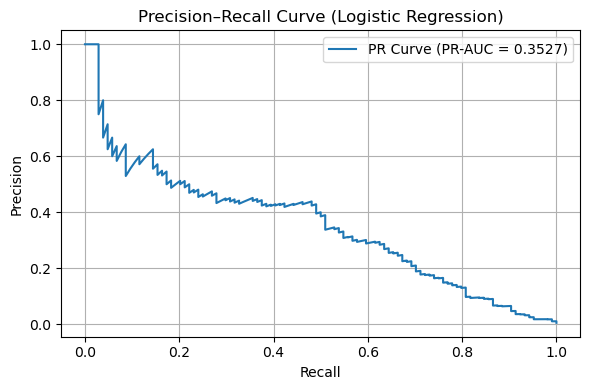

In [39]:
# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)


# Plot PR curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR Curve (PR-AUC = {pr_auc_lr:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

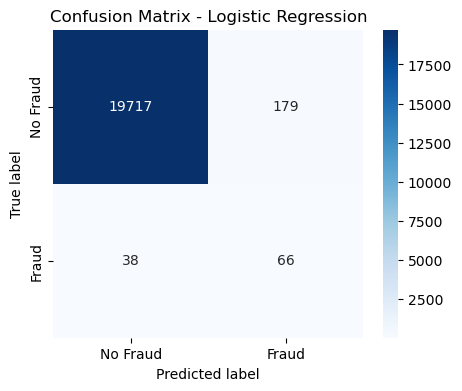

In [40]:
# Generate confusion matrix
# Shows True Positives, False Positives, True Negatives, and False Negatives
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix using heatmap
# Makes error distribution easier to interpret
labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels) #cmap='Reds'
#Label axes for clarity
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#“The model outputs probabilities; the threshold converts probabilities into decisions.”

### Model Training — Tree Models (Decision Tree / Random Forest / XGBoost)

In [41]:
# dropped id types colums with high unique nuerical counts and also dropped high cardibality categorical column

cols_to_drop = [
    "cc_num","trans_num","unix_time","first","last","street",
    "merchant","job","city","zip",
    "trans_date_trans_time","tr_year","tr_minute","tr_day_name",
    "lat","long","merch_lat","merch_long",
    "age_group","dob","'amt_log'",
    "tr_day","tr_month"   # drop raw calendar splits to reduce memorization
]

data2 = data.drop(columns=cols_to_drop, errors="ignore")

In [42]:
data_small, _ = train_test_split(data2,train_size=100_000,stratify=data2['is_fraud'],random_state=42)

# Check ratio preserved
print(data_small['is_fraud'].value_counts(normalize=True))

is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64


In [43]:

X= data_small.drop(columns=['is_fraud'])
y = data_small['is_fraud']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=42)
print("Train ratio:", y_train.mean())
print("Test ratio:", y_test.mean())

Train ratio: 0.0052125
Test ratio: 0.0052


In [44]:
# Feature and Target Variable Definition
target = "is_fraud"

numeric_base = ['city_pop','tr_hour', 'age', 'distance_cust_merchant_km','amt', 'is_weekend', 'is_night', 'txns_last_24h', 'amt_mean_20','amt_vs_mean_ratio']

low_card_cat = ['category', 'gender', 'state']
 
#high_card_cat = [ 'job'] #'merchant', 'city', 'zip'this are redundant columns

In [45]:
# Preprocessing Pipelines for Numeric and Categorical Features
from sklearn.preprocessing import OrdinalEncoder

numeric_tranformer = Pipeline(steps = [('scaler', StandardScaler())])
low_cat_transformer = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown ='ignore',sparse_output=False))])


In [46]:
# pipline for tree input
# remainder='drop'← Delete everything else!
preprocess_tree = ColumnTransformer(
    transformers=[('num', 'passthrough',numeric_base),('low_cat',low_cat_transformer,low_card_cat)],remainder='drop')

### Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
dt = DecisionTreeClassifier(
    criterion="gini",           # measure node purity (default & fast)
    max_depth=3,                # limit tree depth to avoid overfitting
    min_samples_split=10,       # minimum samples needed to split a node
    min_samples_leaf=10,        # minimum samples in a leaf (smooth predictions)
    class_weight="balanced",    # handle class imbalance
    random_state=42             # reproducibility
)

dt_pipe = Pipeline(steps=[('preprocess', preprocess_tree),('model', dt)]) #('smote', SMOTE(sampling_strategy=0.10, random_state=42)),

In [48]:
## cross validation of decision tree

In [49]:
# from sklearn.model_selection import StratifiedKFold, cross_validate

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# scoring = {
#     "roc_auc": "roc_auc",
#    "pr_auc": "average_precision",
#     "recall": "recall",
#     "precision": "precision",
#     "f1": "f1"
# }
# cv_results = cross_validate(dt_pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

# print("CV ROC-AUC:", cv_results["test_roc_auc"].mean())
# print("CV PR-AUC :", cv_results["test_pr_auc"].mean())
# print("CV Recall :", cv_results["test_recall"].mean())
# print("CV F1     :", cv_results["test_f1"].mean())
# print("CV Precision:", cv_results["test_precision"].mean())

In [50]:
dt_pipe.fit(X_train, y_train)
y_pred_dt  = dt_pipe.predict(X_test)
y_proba_dt = dt_pipe.predict_proba(X_test)[:, 1] 

print("Decision Tree – classification report\n")

print(classification_report(y_test, y_pred_dt))

print("Confusion matrix\n")
print(confusion_matrix(y_test, y_pred_dt))

roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
print("test_ROC_AUC:",roc_auc_dt )

# compute recall
recall_dt_test = recall_score(y_test, y_pred_dt)
print('test_recall_score',recall_dt_test)

# Compute PR-AUC
pr_auc_dt = average_precision_score(y_test, y_proba_dt)

# Print PR-AUC value
print("Decision Tree PR-AUC:", pr_auc_dt)

print('===============train results are below==================\n')

y_pred_dt_train  = dt_pipe.predict(X_train)
y_proba_dt_train = dt_pipe.predict_proba(X_train)[:, 1] 

recall_dt_train = recall_score(y_train, y_pred_dt_train)
roc_auc_train_dt = roc_auc_score(y_train, y_proba_dt_train)

print('train_recall_score',recall_dt_train)
print("train_ROC_AUC:",roc_auc_train_dt )

pr_auc_dt_train = average_precision_score(y_train, y_proba_dt_train)
# Print PR-AUC value
print("Decision Tree PR-AUC:", pr_auc_dt_train)

Decision Tree – classification report

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     19896
           1       0.09      0.88      0.17       104

    accuracy                           0.96     20000
   macro avg       0.55      0.92      0.57     20000
weighted avg       0.99      0.96      0.97     20000

Confusion matrix

[[19017   879]
 [   12    92]]
test_ROC_AUC: 0.9698456009712042
test_recall_score 0.8846153846153846
Decision Tree PR-AUC: 0.2647834213856895
===============train results are below==================

train_recall_score 0.8705035971223022
train_ROC_AUC: 0.9655116262342399
Decision Tree PR-AUC: 0.2741307586915529


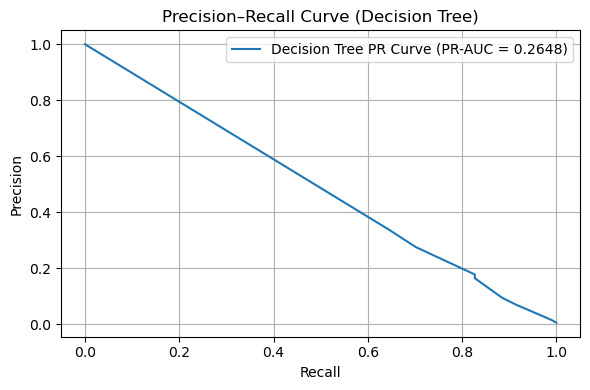

In [51]:
# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
# Compute Precision–Recall curve
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_test, y_proba_dt)

# Plot PR curve
plt.figure(figsize=(6, 4))
plt.plot(recall_dt,precision_dt,label=f"Decision Tree PR Curve (PR-AUC = {pr_auc_dt:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Decision Tree)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

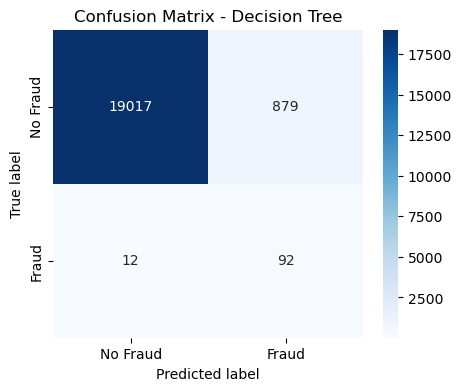

In [52]:
# confusion metrix

cm = confusion_matrix(y_test, y_pred_dt)
labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

### Random Forest

In [53]:

rf = RandomForestClassifier(
    n_estimators=300,              # number of trees (more = stable, slower)
    max_depth=5,                   # limit tree depth to reduce overfitting
    min_samples_split=20,          # minimum samples to split a node
    min_samples_leaf=10,           # minimum samples per leaf (smooth predictions)
    max_features="sqrt",           # features per split (reduces correlation)
    class_weight="balanced_subsample",  # handle class imbalance per tree
    oob_score=True,                # out-of-bag validation estimate
    n_jobs=-1,                     # use all CPU cores
    random_state=42                # reproducibility
)
#('smote', SMOTE(sampling_strategy=0.10, random_state=42)),
rf_pipe = Pipeline(steps=[
    ('preprocess', preprocess_tree),('model', rf)])

## cross validation of random forest model 

In [54]:
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = {
    "roc_auc": "roc_auc",
   "pr_auc": "average_precision",
    "recall": "recall",
    "precision": "precision",
    "f1": "f1"
}
cv_results = cross_validate(rf_pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

print("CV ROC-AUC:", cv_results["test_roc_auc"].mean(),"Std:", cv_results["test_roc_auc"].std())

print("CV PR-AUC :", cv_results["test_pr_auc"].mean(),"Std:", cv_results["test_pr_auc"].std())

print("CV Recall :", cv_results["test_recall"].mean(), "Std:", cv_results["test_recall"].std())

print("CV F1     :", cv_results["test_f1"].mean(), "Std:", cv_results["test_f1"].std())

print("CV Precision:", cv_results["test_precision"].mean(), "Std:", cv_results["test_precision"].std())

CV ROC-AUC: 0.9789928869271689 Std: 0.007753114053238993
CV PR-AUC : 0.6686118685853376 Std: 0.014493386474007079
CV Recall : 0.8609112709832134 Std: 0.02062907737899911
CV F1     : 0.2974771686825179 Std: 0.012166151191491245
CV Precision: 0.17999557943571728 Std: 0.009836070740969398


## performance of random forest model

In [55]:
rf_pipe.fit(X_train, y_train)

y_pred_rf  = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

print("test ROC_AUC:", roc_auc_rf)

recall_score_rf = recall_score(y_test, y_pred_rf) 
print('test recall_score', recall_score_rf)

# Compute PR-AUC
pr_auc_rf = average_precision_score(y_test, y_proba_rf)
# Print PR-AUC value
print("test_Random Forest PR-AUC:", pr_auc_rf)

print('=======train results=======\n')

y_pred_rf_train  = rf_pipe.predict(X_train)
y_proba_rf_train = rf_pipe.predict_proba(X_train)[:, 1]

roc_auc_rf_train = roc_auc_score(y_train, y_proba_rf_train)
print("train ROC_AUC:",roc_auc_rf_train )

recall_score_rf_train = recall_score(y_train, y_pred_rf_train) 
print('train recall_score', recall_score_rf_train)

pr_auc_rf_train = average_precision_score(y_train, y_proba_rf_train)
# Print PR-AUC value
print("train_Random Forest PR-AUC:", pr_auc_rf_train)

=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19896
           1       0.16      0.88      0.28       104

    accuracy                           0.98     20000
   macro avg       0.58      0.93      0.63     20000
weighted avg       0.99      0.98      0.98     20000

test ROC_AUC: 0.9859669318919922
test recall_score 0.875
test_Random Forest PR-AUC: 0.7119515546064995
=======train results=======

train ROC_AUC: 0.9886639925961797
train recall_score 0.882494004796163
train_Random Forest PR-AUC: 0.740333171496057


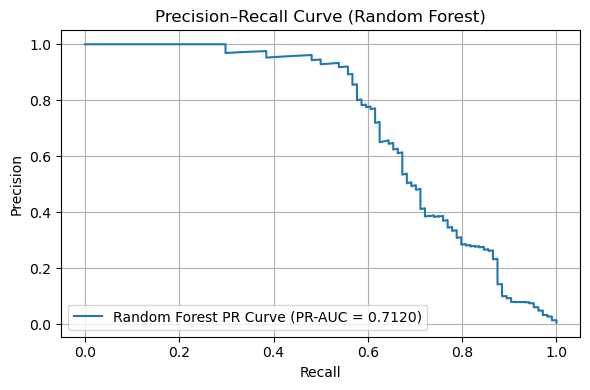

In [56]:
# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.

# Compute Precision–Recall curve
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_proba_rf)

# Plot PR curve
plt.figure(figsize=(6, 4))
plt.plot(recall_rf,precision_rf,label=f"Random Forest PR Curve (PR-AUC = {pr_auc_rf:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Confusion matrix:
 [[19435   461]
 [   13    91]]


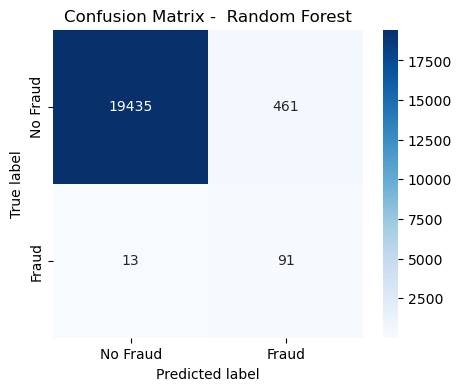

In [57]:
# confusion metrix
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))
# recall

cm = confusion_matrix(y_test, y_pred_rf)

labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix -  Random Forest')
plt.show()

In [58]:
#!pip install xgboost

### Xgboost

In [59]:
from xgboost import XGBClassifier

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()


xgb = XGBClassifier(
    # ---- core ----
    n_estimators=600,          # number of trees (fewer, stronger trees)
    learning_rate=0.05,        # step size; higher LR → fewer trees

    # ---- complexity control ----
    max_depth=2,               # very shallow trees (strong anti-overfit)
    min_child_weight=100,      # avoid learning from tiny / noisy patterns
    gamma=1.5,                 # split only if gain is meaningful

    # ---- randomness ----
    subsample=0.6,             # use 60% rows per tree (regularization)
    colsample_bytree=0.6,      # use 60% features per tree

    # ---- regularization ----
    reg_alpha=10.0,            # L1 regularization (feature sparsity) Sets some Unimportant / noisy features weights exactly to 0 → sparse

    reg_lambda=30.0,           # L2 regularization to shrink weights and reduce overfitting

    # ---- imbalance handling ----
    scale_pos_weight=pos_weight * 0.25,  # control fraud vs non-fraud balance/ # handle class imbalance without over-penalizing fraud

    # ---- misc ----
    tree_method="hist",        # faster histogram-based training
    eval_metric="aucpr",       # optimize PR-AUC (best for fraud)
    random_state=42,           # reproducibility
    n_jobs=-1                  # use all CPU cores
)

#('smote', SMOTE(sampling_strategy=0.10, random_state=42)),
xgb_pipe = Pipeline(steps=[
    ('preprocess', preprocess_tree),  # feature preprocessing for tree-based model
    ('model', xgb)  # XGBoost classifier
])

## cross validation of xgboost model

In [60]:

from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = {
    "roc_auc": "roc_auc",
   "pr_auc": "average_precision",
    "recall": "recall",
    "precision": "precision",
    "f1": "f1"
}
cv_results = cross_validate(xgb_pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

# print("CV ROC-AUC:", cv_results["test_roc_auc"].mean())
# print("CV PR-AUC :", cv_results["test_pr_auc"].mean())
# print("CV Recall :", cv_results["test_recall"].mean())
# print("CV F1     :", cv_results["test_f1"].mean())
# print("CV Precision:", cv_results["test_precision"].mean())

print("CV ROC-AUC:", cv_results["test_roc_auc"].mean(),"Std:", cv_results["test_roc_auc"].std())

print("CV PR-AUC :", cv_results["test_pr_auc"].mean(),"Std:", cv_results["test_pr_auc"].std())

print("CV Recall :", cv_results["test_recall"].mean(), "Std:", cv_results["test_recall"].std())

print("CV F1     :", cv_results["test_f1"].mean(), "Std:", cv_results["test_f1"].std())

print("CV Precision:", cv_results["test_precision"].mean(), "Std:", cv_results["test_precision"].std())

CV ROC-AUC: 0.9900079150194827 Std: 0.004504544331539215
CV PR-AUC : 0.7116912090936737 Std: 0.011109586483948197
CV Recall : 0.8633093525179856 Std: 0.03270547169540975
CV F1     : 0.4535701686951858 Std: 0.004841054134887775
CV Precision: 0.30788466006206333 Std: 0.007600731410731666


## performance of XGboost model 

In [62]:
xgb_pipe.fit(X_train, y_train)

y_pred_xgb = xgb_pipe.predict(X_test)
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))

roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)

print("XGBoost_test ROC_AUC:",roc_auc_xgb )

recall_xgb_test =recall_score(y_test, y_pred_xgb)
print("XGBoost_test Recall:", recall_xgb_test )

# Compute PR-AUC
pr_auc_xgb = average_precision_score(y_test, y_proba_xgb)
# Print PR-AUC value
print("XGBoost_test PR-AUC:", pr_auc_xgb)


print("===============train results======================")

y_pred_xgb_train = xgb_pipe.predict(X_train)
y_proba_xgb_train = xgb_pipe.predict_proba(X_train)[:, 1]

recall_xgb_train = recall_score(y_train, y_pred_xgb_train)
print("xgb_train_Recall:", recall_xgb_train )

roc_auc_xg_train = roc_auc_score(y_train, y_proba_xgb_train)
print("xgb_train ROC_AUC:", roc_auc_xg_train)

pr_auc_xgb_train = average_precision_score(y_train, y_proba_xgb_train)
# Print PR-AUC value
print("XGBoost_train PR-AUC:", pr_auc_xgb_train)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19896
           1       0.31      0.95      0.47       104

    accuracy                           0.99     20000
   macro avg       0.66      0.97      0.73     20000
weighted avg       1.00      0.99      0.99     20000

XGBoost_test ROC_AUC: 0.9967465435649996
XGBoost_test Recall: 0.9519230769230769
XGBoost_test PR-AUC: 0.7843761936638741
===============train results======================
xgb_train_Recall: 0.9400479616306955
xgb_train ROC_AUC: 0.9976357880560334
XGBoost_train PR-AUC: 0.8006506597547047


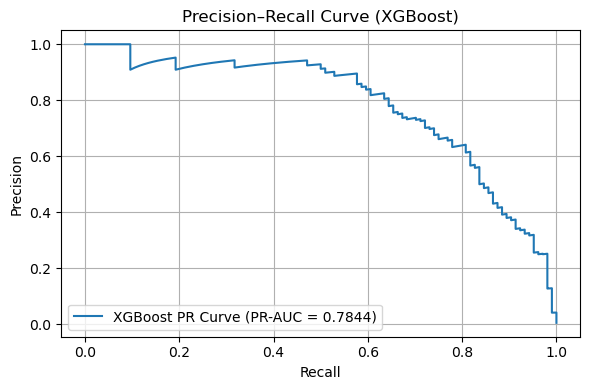

In [63]:
# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.

# Compute Precision–Recall curve
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_proba_xgb)

# Plot PR curve
plt.figure(figsize=(6, 4))
plt.plot( recall_xgb, precision_xgb, label=f"XGBoost PR Curve (PR-AUC = {pr_auc_xgb:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

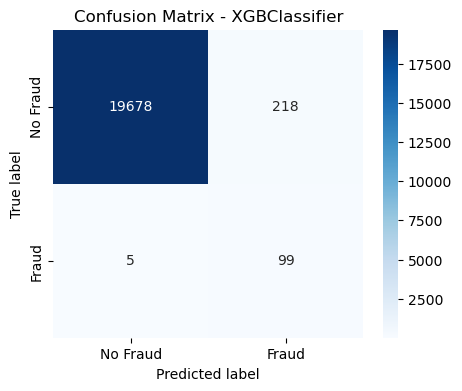

In [64]:
# confusion metrix
cm = confusion_matrix(y_test, y_pred_xgb)

labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - XGBClassifier')
plt.show()

Total features: 77
['num__city_pop' 'num__tr_hour' 'num__age'
 'num__distance_cust_merchant_km' 'num__amt' 'num__is_weekend'
 'num__is_night' 'num__txns_last_24h' 'num__amt_mean_20'
 'num__amt_vs_mean_ratio' 'low_cat__category_entertainment'
 'low_cat__category_food_dining' 'low_cat__category_gas_transport'
 'low_cat__category_grocery_net' 'low_cat__category_grocery_pos'
 'low_cat__category_health_fitness' 'low_cat__category_home'
 'low_cat__category_kids_pets' 'low_cat__category_misc_net'
 'low_cat__category_misc_pos']
Total importances: 77


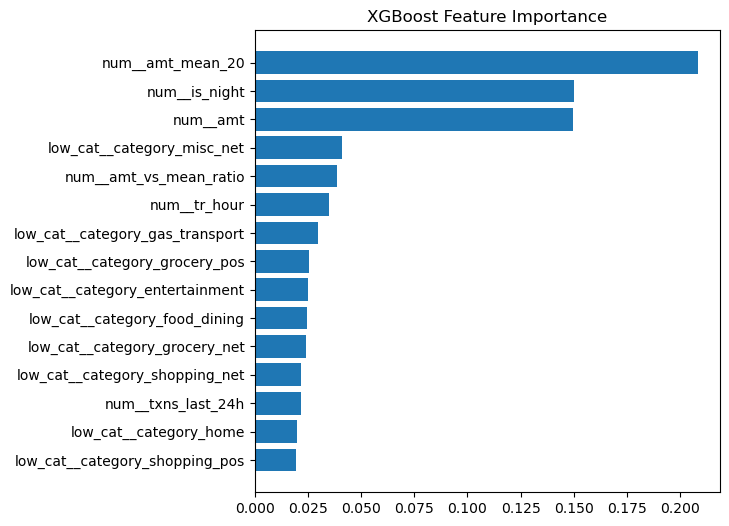

In [65]:

xgb_estimator= xgb_pipe.named_steps['model']
# extract feature names from pipline
preprocessor = xgb_pipe.named_steps["preprocess"]

all_features = preprocessor.get_feature_names_out()
print("Total features:", len(all_features))
print(all_features[:20])

# extract  XGBoost model importances 
#xgb_estimator= xgb_model.named_steps['xgboost']
importances = xgb_estimator.feature_importances_
print("Total importances:", len(importances))

xgb_importance_df = pd.DataFrame({"all_features":all_features,"importances":importances}
                                ).sort_values("importances",ascending=False).reset_index(drop=True).head(15)
xgb_importance_df.head(10)

plt.figure(figsize=(6, 6))
plt.barh(xgb_importance_df["all_features"],xgb_importance_df["importances"])
plt.title("XGBoost Feature Importance")
#plt.invert_yaxis()
# plt.xlabel("Importance (Gain)")
# plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

### Thresold tunning 

In [66]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
threshold = 0.20 
# y_pred_lgb  = lgbm_pipe.predict(X_test)
# y_proba_lgb = lgbm_pipe.predict_proba(X_test)[:, 1]

y_pred = (y_proba_xgb >= threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Threshold:", threshold)
print("Fraud Recall (catch rate):", recall_score(y_test, y_pred))
print("Fraud Precision:", precision_score(y_test,y_pred))
print("Fraud F1:", f1_score(y_test, y_pred))
print("TP (fraud caught):", tp)
print("FN (fraud missed):", fn)
print("FP (false alerts):", fp)
print("Alert rate:", (tp+fp)/len(y_test))

Threshold: 0.2
Fraud Recall (catch rate): 0.9807692307692307
Fraud Precision: 0.15384615384615385
Fraud F1: 0.26597131681877445
TP (fraud caught): 102
FN (fraud missed): 2
FP (false alerts): 561
Alert rate: 0.03315


In [67]:
# recall value from all models 
# recall_dummy = recall_score(y_test, y_pred_dummy)
# recall_log_reg   = recall_score(y_test, y_pred)
# recall_dt        = recall_score(y_test, y_pred_dt)
# recall_rf        = recall_score(y_test, y_pred_rf)
# recall_xgb       = recall_score(y_test, y_pred_xgb)


In [68]:
# # plotting bar plot for various recall results obtained from various models
# recall_data = {"model": ["recall_dummy", "Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"],
#     "recall": [ recall_dummy,recall_log_reg, recall_dt, recall_rf, recall_xgb]
# }

# recall_df = pd.DataFrame(recall_data)

# print(recall_df)

# # bar plot
# plt.figure(figsize=(8, 5))
# sns.barplot(data=recall_df, x="model", y="recall")

# plt.ylim(0, 1)  # recall is between 0 and 1
# plt.title("Recall Comparison Across Models")
# plt.ylabel("Recall")
# plt.xlabel("Model")
# plt.xticks(rotation=20)
# plt.tight_layout()
# plt.show()

In [69]:
results_df = pd.DataFrame({
    "Model": ["Dummy", "Logistic", "Decision Tree", "Random Forest", "XGBoost"],

    "Train Recall": [recall_dummy_train, roc_auc_lr_train, recall_dt_train, recall_score_rf_train, recall_xgb_train],

    "Test Recall": [recall_dummy, recall_score_lr, recall_dt_test, recall_score_rf, recall_xgb_test],

    "Train PR-AUC": [0,  pr_auc_train, pr_auc_dt_train, pr_auc_rf_train, pr_auc_xgb_train],

    "Test PR-AUC": [0,pr_auc_lr, pr_auc_dt, pr_auc_rf, pr_auc_xgb]})


In [70]:
results_df

,Model,Train Recall,Test Recall,Train PR-AUC,Test PR-AUC
0,Dummy,0.000000,0.000000,0.000000,0.000000
1,Logistic,0.971293,0.634615,0.305882,0.352661
2,Decision Tree,0.870504,0.884615,0.274131,0.264783
3,Random Forest,0.882494,0.875000,0.740333,0.711952
4,XGBoost,0.940048,0.951923,0.800651,0.784376


In [71]:
# Melt dataframe for easier plotting
# results_melted = results_df.melt(id_vars="Model",
#                                  var_name="Metric",
#                                  value_name="Score")

# plt.figure(figsize=(12,6))
# sns.barplot(data=results_melted, x="Model", y="Score", hue="Metric")

# plt.xticks(rotation=30)
# plt.title("Train vs Test Recall and PR-AUC Comparison")
# plt.tight_layout()
# plt.show()

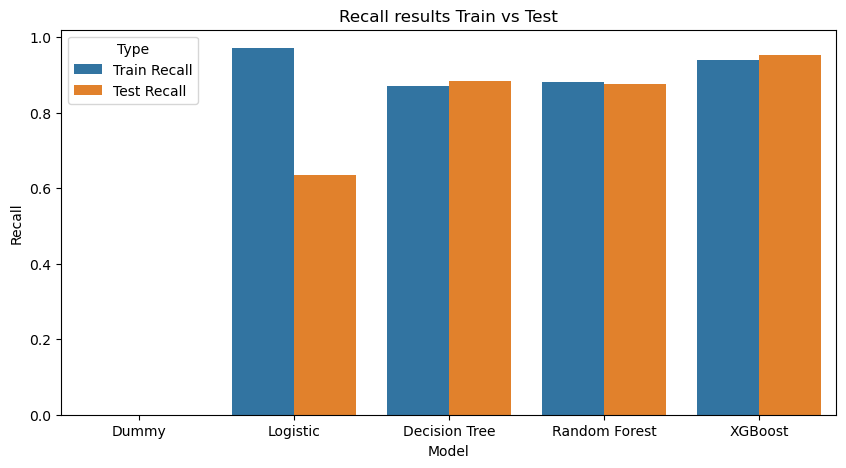

In [77]:
recall_df = results_df[["Model", "Train Recall", "Test Recall"]]

recall_melt = recall_df.melt(id_vars="Model",
                             var_name="Type",
                             value_name="Recall")

plt.figure(figsize=(10,5))
sns.barplot(data=recall_melt, x="Model", y="Recall", hue="Type")
plt.title("Recall results Train vs Test")
#plt.xticks(rotation=30)
plt.show()

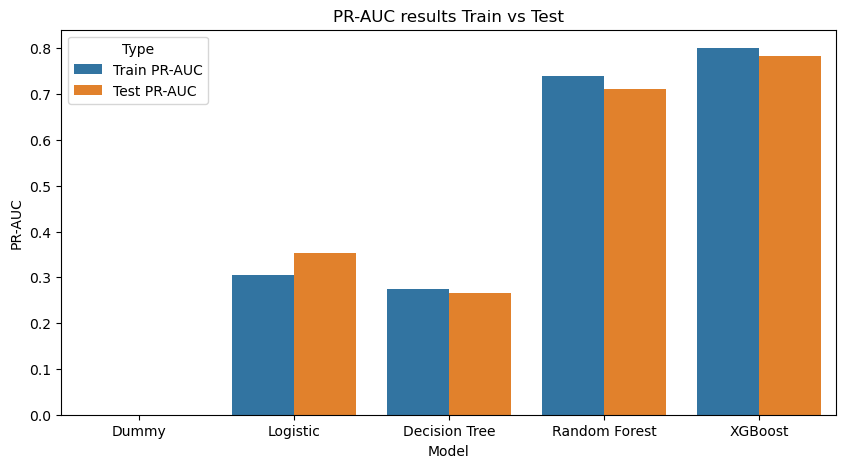

In [76]:
prauc_df = results_df[["Model", "Train PR-AUC", "Test PR-AUC"]]

prauc_melt = prauc_df.melt(id_vars="Model",
                           var_name="Type",
                           value_name="PR-AUC")

plt.figure(figsize=(10,5))
sns.barplot(data=prauc_melt, x="Model", y="PR-AUC", hue="Type")
plt.title("PR-AUC results Train vs Test" )
#plt.xticks(rotation=30)
plt.show()

In [74]:
# # train
# roc_auc_dummy_train = roc_auc_score(y_train, y_prob_train_dummy)
# recall_dummy_train = recall_score(y_train, y_prob_train_dummy)
# # test 
# roc_auc_dummy = roc_auc_score(y_test, y_prob_dummy)
# recall_dummy = recall_score(y_test, y_pred_dummy)


# ##logistic regression
# # train
# roc_auc_lr_train = roc_auc_score(y_train, y_proba_train)
# roc_auc_lr_train = roc_auc_score(y_train, y_proba_train)
# pr_auc_train = average_precision_score(y_train, y_proba_train)

# # test 
# recall_score_lr = recall_score(y_test, y_pred)
# pr_auc_lr = average_precision_score(y_test, y_proba)
# roc_auc_lr = roc_auc_score(y_test, y_proba)

# # decision tree

# # train
# recall_dt_train = recall_score(y_train, y_pred_dt_train)
# roc_auc_train_dt = roc_auc_score(y_train, y_proba_dt_train)
# pr_auc_dt_train = average_precision_score(y_train, y_proba_dt_train)

# # test
# roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
# recall_dt = recall_score(y_test, y_pred_dt)
# pr_auc_dt = average_precision_score(y_test, y_proba_dt)

# # randoom forest

# # train
# roc_auc_rf_train = roc_auc_score(y_train, y_proba_rf_train)
# recall_score_rf_train = recall_score(y_train, y_pred_rf_train) 
# pr_auc_rf_train = average_precision_score(y_train, y_proba_rf_train)

# # test
# recall_score_rf = recall_score(y_test, y_pred_rf)
# pr_auc_rf = average_precision_score(y_test, y_proba_rf)
# roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

# # xgboost
# # train 
# recall_xgb_train= recall_score(y_train, y_pred_xgb_train)
# roc_auc_xg_train = roc_auc_score(y_train, y_proba_xgb_train)
# pr_auc_xgb_train = average_precision_score(y_train, y_proba_xgb_train)

# #test
# roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
# recall_xgb =recall_score(y_test, y_pred_xgb)
# pr_auc_xgb = average_precision_score(y_test, y_proba_xgb)